# import files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style = 'darkgrid', palette = 'bright')

In [2]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

# read data

In [3]:
sales_train = pd.read_csv('./competitive-data-science-predict-future-sales/sales_train_v2.csv')
items = pd.read_csv('./competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('./competitive-data-science-predict-future-sales/item_categories.csv')
shops = pd.read_csv('./competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('./competitive-data-science-predict-future-sales/test.csv/test.csv')
sample_submission = pd.read_csv('./competitive-data-science-predict-future-sales/sample_submission.csv')

# check head of the data

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
sales_train.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
items.isnull().any()

item_name           False
item_id             False
item_category_id    False
dtype: bool

In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
item_categories.isnull().any()

item_category_name    False
item_category_id      False
dtype: bool

In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
shops.isnull().any()

shop_name    False
shop_id      False
dtype: bool

In [12]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## sales_train feature engineering

In [14]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


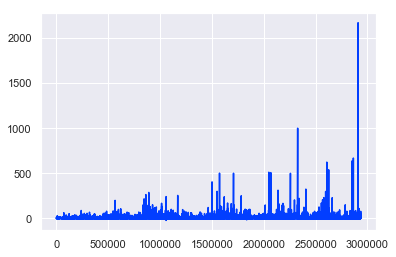

In [15]:
plt.plot(sales_train['item_cnt_day'])

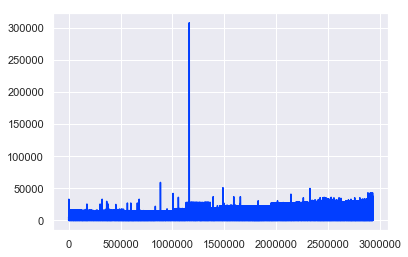

In [16]:
plt.plot(sales_train['item_price'])

In [17]:
# get rid of outliers
sales_train = sales_train[sales_train.item_price<100000]
sales_train = sales_train[sales_train.item_cnt_day<1001]

In [18]:
median = sales_train.item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

## item_categories Engineering

In [19]:
item_category_ns = item_categories['item_category_name'].str.split('-', expand = True)
item_category_ns.rename(columns = {0: 'i_name1', 1: 'i_name2', 2: 'i_name3'}, inplace = True)
item_category_ns.head()

,i_name1,i_name2,i_name3
0,PC,Гарнитуры/Наушники,None
1,Аксессуары,PS2,None
2,Аксессуары,PS3,None
3,Аксессуары,PS4,None
4,Аксессуары,PSP,None


In [20]:
item_category_ns['i_name1'] = item_category_ns['i_name1'].fillna('NoWord')
item_category_ns['i_name2'] = item_category_ns['i_name2'].fillna('NoWord')
item_category_ns['i_name3'] = item_category_ns['i_name3'].fillna('NoWord')
item_category_ns.head()

,i_name1,i_name2,i_name3
0,PC,Гарнитуры/Наушники,NoWord
1,Аксессуары,PS2,NoWord
2,Аксессуары,PS3,NoWord
3,Аксессуары,PS4,NoWord
4,Аксессуары,PSP,NoWord


In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(item_category_ns['i_name1'])
item_category_ns['i_name1'] = le.transform(item_category_ns['i_name1'])

le = LabelEncoder()
le = le.fit(item_category_ns['i_name2'])
item_category_ns['i_name2'] = le.transform(item_category_ns['i_name2'])

le = le.fit(item_category_ns['i_name3'])
item_category_ns['i_name3'] = le.transform(item_category_ns['i_name3'])

item_category_ns.head()

,i_name1,i_name2,i_name3
0,0,28,0
1,1,9,0
2,1,10,0
3,1,11,0
4,1,13,0


In [22]:
item_category_eg = pd.concat([item_categories, item_category_ns], axis = 1)
item_category_eg = item_category_eg.drop("item_category_name", axis = 1)
item_category_eg.head()

,item_category_id,i_name1,i_name2,i_name3
0,0,0,28,0
1,1,1,9,0
2,2,1,10,0
3,3,1,11,0
4,4,1,13,0


## shops Engineering

In [23]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [24]:
shops.shape

(60, 2)

In [25]:
shops_ns = shops['shop_name'].str.split(' ', expand = True)
shops_ns.head(20)

,0,1,2,3,4,5
0,!Якутск,"Орджоникидзе,",56,фран,None,None
1,!Якутск,ТЦ,"""Центральный""",фран,None,None
2,Адыгея,ТЦ,"""Мега""",None,None,None
3,Балашиха,ТРК,"""Октябрь-Киномир""",None,None,None
4,Волжский,ТЦ,"""Волга","Молл""",None,None
5,Вологда,ТРЦ,"""Мармелад""",None,None,None
6,Воронеж,"(Плехановская,",13),None,None,None
7,Воронеж,ТРЦ,"""Максимир""",None,None,None
8,Воронеж,ТРЦ,Сити-Парк,"""Град""",None,None
9,Выездная,Торговля,None,None,None,None


In [26]:
shops_ns.rename(columns = {0: 's_name1', 1: 's_name2', 2: 's_name3', 3: 's_name4', 4: 's_name5', 5: 's_name6', 6: 's_name7'}, inplace = True)

for i in range(6):
    shops_ns['s_name' + str(i + 1)] = shops_ns['s_name' + str(i + 1)].fillna('NoWord')
    
    le = le.fit(shops_ns['s_name' + str(i + 1)])
    shops_ns['s_name' + str(i + 1)] = le.transform(shops_ns['s_name' + str(i + 1)])

shops_ns.head()

,s_name1,s_name2,s_name3,s_name4,s_name5,s_name6
0,0,4,40,21,1,2
1,0,9,37,21,1,2
2,1,9,20,9,1,2
3,2,7,25,9,1,2
4,3,9,9,15,1,2


In [27]:
shops_eg = pd.concat([shops, shops_ns], axis = 1)
shops_eg = shops_eg.drop("shop_name", axis = 1)
shops_eg.head()

,shop_id,s_name1,s_name2,s_name3,s_name4,s_name5,s_name6
0,0,0,4,40,21,1,2
1,1,0,9,37,21,1,2
2,2,1,9,20,9,1,2
3,3,2,7,25,9,1,2
4,4,3,9,9,15,1,2


## merge data

In [28]:
from itertools import product

all_data = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    all_data.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
all_data = pd.DataFrame(np.vstack(all_data), columns=cols)
all_data['date_block_num'] = all_data['date_block_num'].astype(np.int8)
all_data['shop_id'] = all_data['shop_id'].astype(np.int8)
all_data['item_id'] = all_data['item_id'].astype(np.int16)
all_data.sort_values(cols,inplace=True)

sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=cols, how='left')
all_data['item_cnt_month'] = (all_data['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

## make test features

In [29]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [30]:
test['year'] = 2015
test['month'] = 11
# test = test.drop('item_name', axis = 1).sort_values(by = 'ID').set_index('ID')

In [31]:
all_data = pd.concat([all_data, test], ignore_index=True, sort=False, keys=cols)
all_data.fillna(0, inplace=True) # 34 month

## merge traindata and testdata

In [32]:
all_data = pd.merge(all_data, shops_eg, on=['shop_id'], how='left')
all_data = pd.merge(all_data, items, on=['item_id'], how='left')
all_data = pd.merge(all_data, item_category_eg, on=['item_category_id'], how='left')
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)

In [33]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID', 'year',
       'month', 's_name1', 's_name2', 's_name3', 's_name4', 's_name5',
       's_name6', 'item_name', 'item_category_id', 'i_name1', 'i_name2',
       'i_name3'],
      dtype='object')

## lag feature

In [34]:
def get_lag_df(df, lags, c_name):
    tmp = df[['date_block_num', 'shop_id', 'item_id', c_name]].copy()
    for i in lags:
        tmp.columns = ['date_block_num', 'shop_id', 'item_id', c_name + '_lag_' + str(i)]
        tmp.date_block_num += i
        df = pd.merge(df, tmp, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
    return df

In [35]:
all_data = get_lag_df(all_data, [1,2,3,4,12], 'item_cnt_month')

In [36]:
group = all_data.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num'], how='left')
all_data['date_avg_item_cnt'] = all_data['date_avg_item_cnt'].astype(np.float16)
all_data = get_lag_df(all_data, [1, 2, 3, 4, 12], 'date_avg_item_cnt')
all_data.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [37]:
group = all_data.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','item_id'], how='left')
all_data['date_item_avg_item_cnt'] = all_data['date_item_avg_item_cnt'].astype(np.float16)
all_data = get_lag_df(all_data, [1, 2, 3, 4, 12], 'date_item_avg_item_cnt')
all_data.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [38]:
group = all_data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','shop_id'], how='left')
all_data['date_shop_avg_item_cnt'] = all_data['date_shop_avg_item_cnt'].astype(np.float16)
all_data = get_lag_df(all_data, [1, 2, 3, 4, 12], 'date_shop_avg_item_cnt')
all_data.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [39]:
group = all_data.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num','item_category_id'], how='left')
all_data['date_cat_avg_item_cnt'] = all_data['date_cat_avg_item_cnt'].astype(np.float16)
all_data = get_lag_df(all_data, [1, 2, 3, 4, 12], 'date_cat_avg_item_cnt')
all_data.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [40]:
group = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
all_data['date_shop_cat_avg_item_cnt'] = all_data['date_shop_cat_avg_item_cnt'].astype(np.float16)
all_data = get_lag_df(all_data, [1, 2, 3, 4, 12], 'date_shop_cat_avg_item_cnt')
all_data.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

# xgboost

In [41]:
all_data = all_data[all_data.date_block_num > 11]

In [42]:
all_data = all_data.fillna(0)

In [43]:
all_data = all_data.drop(['item_name'], axis = 1)

In [44]:
xgb_params = {'max_depth':12,  
         'subsample':1, 
         'min_child_weight':0.5,
         'eta':0.3,
         'num_round':1000, 
         'seed':42,  
         'silent':0,
         'eval_metric':'rmse',
         'early_stopping_rounds':100
        }


In [50]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
X = all_data[all_data.date_block_num < 34].drop(['item_cnt_month'], axis=1)
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns)
y = all_data[all_data.date_block_num < 34]['item_cnt_month']
X_test = all_data[all_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
scaler2 = StandardScaler()
scaler2.fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)    
prediction = np.zeros(len(X_test))
prediction_lgb = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
        valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

        watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
        model = xgb.train(dtrain=train_data, evals=watchlist, verbose_eval=500, params=xgb_params)
        y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        prediction += y_pred
        
prediction /= n_fold


C:\Users\knaas\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int32, float16, int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\knaas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int8, int32, float16, int16, float64 were all converted to float64 by StandardScaler.
  
C:\Users\knaas\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int32, float16, int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\knaas\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int8, int32, float16, int16, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


[07:32:25] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[07:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5930 extra nodes, 0 pruned nodes, max_depth=12
[0]	train-rmse:1.03683	valid_data-rmse:1.05612
[07:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5696 extra nodes, 0 pruned nodes, max_depth=12
[07:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5714 extra nodes, 0 pruned nodes, max_depth=12
[07:32:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5748 extra nodes, 0 pruned nodes, max_depth=12
[07:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5542 extra nodes, 0 pruned nodes, max_depth=12
[07:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5410 extra nodes, 0 pruned nodes, max_depth=12
[07:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5260 extra nodes, 0 pru

[75]	valid_0's rmse: 0.842804
[76]	valid_0's rmse: 0.842592
[77]	valid_0's rmse: 0.842351
[78]	valid_0's rmse: 0.841995
[79]	valid_0's rmse: 0.841455
[80]	valid_0's rmse: 0.840964
[81]	valid_0's rmse: 0.840791
[82]	valid_0's rmse: 0.840582
[83]	valid_0's rmse: 0.840432
[84]	valid_0's rmse: 0.840305
[85]	valid_0's rmse: 0.839922
[86]	valid_0's rmse: 0.83973
[87]	valid_0's rmse: 0.839473
[88]	valid_0's rmse: 0.839243
[89]	valid_0's rmse: 0.839
[90]	valid_0's rmse: 0.838765
[91]	valid_0's rmse: 0.838574
[92]	valid_0's rmse: 0.838338
[93]	valid_0's rmse: 0.838098
[94]	valid_0's rmse: 0.837844
[95]	valid_0's rmse: 0.837278
[96]	valid_0's rmse: 0.837069
[97]	valid_0's rmse: 0.836963
[98]	valid_0's rmse: 0.836731
[99]	valid_0's rmse: 0.836529
[100]	valid_0's rmse: 0.836251
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.836251
[07:35:04] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine),

[46]	valid_0's rmse: 0.864887
[47]	valid_0's rmse: 0.864443
[48]	valid_0's rmse: 0.863953
[49]	valid_0's rmse: 0.863395
[50]	valid_0's rmse: 0.862874
[51]	valid_0's rmse: 0.862349
[52]	valid_0's rmse: 0.861952
[53]	valid_0's rmse: 0.860776
[54]	valid_0's rmse: 0.860104
[55]	valid_0's rmse: 0.859584
[56]	valid_0's rmse: 0.858942
[57]	valid_0's rmse: 0.858494
[58]	valid_0's rmse: 0.857898
[59]	valid_0's rmse: 0.857492
[60]	valid_0's rmse: 0.857118
[61]	valid_0's rmse: 0.856755
[62]	valid_0's rmse: 0.856123
[63]	valid_0's rmse: 0.855768
[64]	valid_0's rmse: 0.855516
[65]	valid_0's rmse: 0.85527
[66]	valid_0's rmse: 0.854996
[67]	valid_0's rmse: 0.853534
[68]	valid_0's rmse: 0.852795
[69]	valid_0's rmse: 0.852351
[70]	valid_0's rmse: 0.851753
[71]	valid_0's rmse: 0.850596
[72]	valid_0's rmse: 0.84994
[73]	valid_0's rmse: 0.849569
[74]	valid_0's rmse: 0.849198
[75]	valid_0's rmse: 0.848811
[76]	valid_0's rmse: 0.848666
[77]	valid_0's rmse: 0.848413
[78]	valid_0's rmse: 0.848042
[79]	valid_0

In [53]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": prediction
})
submission.to_csv('xgb_submission_0706.csv', index=False)